# Active Learning with ConvNP Model, Dynamic Random Sampling, and RMSE by Iteration

In this notebook, we implement **active learning** to improve model training by selecting the most informative data points for the model to focus on. Specifically, we:
1. Preprocess the dataset and define helper functions for data normalization.
2. Use a **Greedy Algorithm** for active learning to iteratively sample the most uncertain data points.
3. Implement **Standard Deviation Acquisition Function** to guide the model to focus on uncertain regions in the data.
4. Visualize the placement of new data points selected by active learning.

Let’s begin by importing necessary packages and defining helper functions.

Please Note that this file requires a batch job to run. It requires more memory than you should be requesting in jupyterlab


## Step 1: Import Packages

We import the libraries required for:
- Data manipulation and visualization (`xarray`, `pandas`, `matplotlib`).
- Geospatial operations (`cartopy`).
- Active learning (`deepsensor`).
- PyTorch for model training and inference.

We also import local helper functions like `standardize_dates` for normalizing the 'time' dimension to date-only precision and `generate_random_coordinates` to sample random coordinates from the lake mask.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import os

import json
import torch  

import torch
import deepsensor.torch
import sys 
sys.path.append(os.path.abspath(".."))
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.model.nps import construct_neural_process
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device

# Local package utilities
from deepsensor_greatlakes.utils import standardize_dates, generate_random_coordinates
from deepsensor_greatlakes.model import save_model, load_convnp_model
def transform_ice(da):
    da = xr.DataArray(da)  # Ensure input is always an xarray.DataArray
    nan_mask = da.isnull()  # This correctly creates a mask in xarray
    transformed = xr.where(da > 0.2, 0, 1)  # Apply thresholding
    transformed = transformed.where(~nan_mask, np.nan)  # Preserve NaNs
    return transformed

In [2]:
set_gpu_default_device()

## Step 2: Data Inventory and Preprocessing

In this section, we load and preprocess the required datasets for active learning:
- **Ice Concentration**: A dataset containing information about ice cover over time in the Great Lakes.
- **GLSEA (Sea Surface Temperature)**: A dataset representing sea surface temperature over time.
- **Bathymetry**: A dataset of underwater topography.
- **Lake Mask**: A binary mask indicating water presence.

These datasets are loaded from U-M HPC storage and undergo preprocessing, such as replacing invalid land values with `NaN` and standardizing the time dimension.


In [3]:
# Training/data config (adapted for Great Lakes)
# Make sure these line up with the training and val dates from training: i.e. what you trained run00 or other on
# data_range = ("2000-01-01", "2002-12-31")
# train_range = ("2000-01-01", "2001-12-31")
# val_range = ("2002-01-01", "2002-12-31")
# date_subsample_factor = 30

data_range = ("2009-01-01", "2010-12-31")
train_range = ("2009-01-01", "2009-12-31")
val_range = ("2010-01-01", "2010-12-31")
date_subsample_factor = 30
extent = "great_lakes"

deepsensor_folder = "../saved_models/run00/"
#deepsensor_folder = "../deepsensor_config/"

In [4]:
# Path to the files on U-M HPC
bathymetry_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/bathymetry/interpolated_bathymetry.nc'
mask_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/masks/lakemask.nc'
ice_concentration_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/NSIDC/ice_concentration.zarr'
glsea_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA_combined.zarr'
glsea3_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_combined.zarr'

## Step 3: Loading Temporal Datasets (Ice Concentration and GLSEA)

In this section, we load the **Ice Concentration** and **GLSEA** datasets stored in Zarr format. These datasets contain temporal data on ice cover and sea surface temperature.

Preprocessing steps include:
1. Replacing invalid land values (denoted by `-1`) with `NaN`.
2. Converting the time dimension to date-only format.
3. Dropping unnecessary variables, such as **CRS**.

We proceed by loading and preprocessing these datasets.


In [5]:
# Open the Zarr stores
ice_concentration_raw = xr.open_zarr(ice_concentration_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea_raw = xr.open_zarr(glsea_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea3_raw = xr.open_zarr(glsea3_path, chunks={'time': 366, 'lat': 200, 'lon': 200})

# Replace -1 (land value) with NaN
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)
glsea3_raw = standardize_dates(glsea3_raw)

#Note, some dates are not accessible with GLSEA3, try using GLSEA here instead
ice_mask = xr.apply_ufunc(
    transform_ice,
    glsea3_raw["sst"],  # Ensure function applies only to 'sst' DataArray
    dask="allowed",  # Ensures correct Dask processing
    output_dtypes=[glsea3_raw["sst"].dtype],
    keep_attrs=True,  # Preserve metadata
)
ice_mask = ice_mask.rename("binary_ice_indicator")
print(ice_mask)

# Drop CRS - not needed
# Information about glsea as it is opened
glsea_raw = glsea_raw.drop_vars('crs')
glsea3_raw = glsea3_raw.drop_vars('crs')
glsea_raw.info()

<xarray.DataArray 'binary_ice_indicator' (time: 6226, lat: 838, lon: 1181)> Size: 49GB
dask.array<where, shape=(6226, 838, 1181), dtype=float64, chunksize=(366, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
  * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * time     (time) datetime64[s] 50kB 2006-12-11 2006-12-12 ... 2023-12-31
Attributes:
    grid_mapping:   crs
    long_name:      Temperature
    standard_name:  sea_water_temperature
    units:          Celsius
xarray.Dataset {
dimensions:
	lat = 838 ;
	lon = 1181 ;
	time = 10221 ;

variables:
	float64 lat(lat) ;
		lat:axis = Y ;
		lat:long_name = latitude ;
		lat:standard_name = projection_y_coordinate ;
		lat:units = degrees_north ;
	float64 lon(lon) ;
		lon:axis = X ;
		lon:long_name = longitude ;
		lon:standard_name = projection_x_coordinate ;
		lon:units = degrees_east ;
	float32 sst(time, lat, lon) ;
		sst:grid_mapping = 

## Step 4: Loading Static Datasets (Lake Mask and Bathymetry)

We now load two static datasets:
- **Bathymetry**: The underwater features of the Great Lakes.
- **Lake Mask**: A binary mask that identifies water areas.

These datasets are opened from NetCDF files and processed similarly to the temporal datasets.


In [6]:
# Open the NetCDF files using xarray with gcsfs
# Static Context Datasets
bathymetry_raw = xr.open_dataset(bathymetry_path)
lakemask_raw = xr.open_dataset(mask_path)


## Step 5: Initialize the Data Processor

The **DataProcessor** from DeepSensor is used to preprocess and normalize the data. It standardizes and normalizes the datasets for model training, ensuring consistency in feature scaling across training examples.

We initialize the **DataProcessor** and apply it to the datasets.


In [7]:
data_processor = DataProcessor("../deepsensor_config/")
print(data_processor)

DataProcessor with normalisation params:
{'bathymetry': {'method': 'min_max',
                'params': {'max': 316.62872313037894,
                           'min': 9.999999999999998}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (38.8749871947229, 55.4132976408956), 'name': 'lat'},
            'x2': {'map': (-92.4199507342304, -75.8816402880577),
                   'name': 'lon'}},
 'mask': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 'sst': {'method': 'mean_std',
         'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}}}


In [8]:
glsea = data_processor(glsea_raw)
# process the bathymetry and lake
aux_ds, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [9]:
ice_mask = ice_mask.chunk({"time": 1, "lat": 838, "lon": 1181})
_ = data_processor(ice_mask.sel(time=slice("2008-01-01", "2008-04-01")))
ice_ds = data_processor(ice_mask)

dates = pd.date_range(glsea_raw.time.values.min(), glsea_raw.time.values.max(), freq="D")
dates = pd.to_datetime(dates).normalize()  # This will set all times to 00:00:00

In [10]:
# Generate training and validation tasks
train_dates = pd.date_range(train_range[0], train_range[1])[::date_subsample_factor]
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

# Standardize the dates so they are datetime64[D] (date only, no time)
train_dates = pd.to_datetime(train_dates).normalize()  # This will set the time to 00:00:00
val_dates = pd.to_datetime(val_dates).normalize()      # This will set the time to 00:00:00

In [11]:
# Initializes Circular Seasonal Nature, allows model to take seasonal patterns into account
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = standardize_dates(doy_ds["cos_D"])
aux_ds["sin_D"] = standardize_dates(doy_ds["sin_D"])
aux_ds

<xarray.Dataset> Size: 941kB
Dimensions:     (x1: 240, x2: 360, time: 10227)
Coordinates:
  * x1          (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2          (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9791 0.9818
  * time        (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
Data variables:
    bathymetry  (x1, x2) float64 691kB nan nan nan nan nan ... nan nan nan nan
    cos_D       (time) float64 82kB 0.9999 0.9994 0.9987 ... 0.9993 0.9998 1.0
    sin_D       (time) float64 82kB 0.0172 0.0344 0.05158 ... -0.0215 -0.004301

In [13]:
# Initializes previously defined context sets and target sets in a task
task_loader = TaskLoader(context=[glsea, aux_ds, ice_ds, lakemask], target=glsea)

## Step 7: Custom Save and Load Functions

Since the built-in save and load functions are broken, we define custom save and load functions to handle the **ConvNP** model and its configuration. The functions will:
1. **Save the model**: Save both the model weights and configuration to disk.
2. **Load the model**: Reload the model from disk, including weights and configuration, to resume training or inference.

These functions are defined near the top of this notebook.


In [14]:
# Initialize previously trained model
#If this gives you an error, it is most likely due to CUDA not working properly on the notebook, try it in a batch job, or wait because it usually works here
# No debugging because sometimes it briefly stops working... not sure why
loaded_model = load_convnp_model(deepsensor_folder, data_processor, task_loader)


Attempting to instantiate ConvNP model (randomly initialized initially):
Architectural config for construct_neural_process (passed as **kwargs): {'dim_x': 2, 'dim_yc': [1, 3, 1], 'dim_yt': 1, 'dim_aux_t': 0, 'dim_lv': 0, 'conv_arch': 'unet', 'unet_channels': [64, 64, 64, 64], 'unet_resize_convs': True, 'unet_resize_conv_interp_method': 'bilinear', 'aux_t_mlp_layers': None, 'likelihood': 'het', 'unet_kernels': 5, 'internal_density': 1180, 'encoder_scales': [0.0004237288, 0.0009355429, 0.0004237288], 'encoder_scales_learnable': False, 'decoder_scale': 0.000847457627118644, 'decoder_scale_learnable': False, 'num_basis_functions': 64, 'epsilon': 0.01}


In [15]:
# Visualize configurations for debugging
loaded_model.config
loaded_model.data_processor.config

{'coords': {'time': {'name': 'time'},
  'x1': {'name': 'lat', 'map': (38.8749871947229, 55.4132976408956)},
  'x2': {'name': 'lon', 'map': (-92.4199507342304, -75.8816402880577)}},
 'sst': {'method': 'mean_std',
  'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}},
 'bathymetry': {'method': 'min_max',
  'params': {'min': 9.999999999999998, 'max': 316.62872313037894}},
 'mask': {'method': 'min_max', 'params': {'min': 0.0, 'max': 1.0}},
 'binary_ice_indicator': {'method': 'mean_std',
  'params': {'mean': 0.6185053417359287, 'std': 0.4857535218400889}},
 'dummy': {'method': 'min_max',
  'params': {'min': 0.001405439475848036, 'max': 0.990229593377748}}}

In [16]:
# Load model
model = loaded_model

## Step 8: Active Learning with Greedy Algorithm

Active learning helps the model focus on the most informative data points by selecting points where it is most uncertain. We use the **Greedy Algorithm** from DeepSensor to select the most uncertain points based on the current model's predictions.

In this section, we set up the **GreedyAlgorithm** with:
- **Context and target data**: GLSEA data for the context and the same GLSEA for the target.
- **Mask data**: To restrict the selection to valid areas within the lake.

We run the active learning process, selecting new data points for training based on model uncertainty.


<xarray.DataArray 'mask' (x1: 838, x2: 1181)> Size: 4MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x2       (x2) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * x1       (x1) float64 7kB 38.87 38.89 38.9 38.92 ... 50.56 50.58 50.59 50.61
Attributes:
    standard_name:  binary land mask
    grid_mapping:   crs
Loading dataset from: gl_temp_data_cleaned.nc
<xarray.Dataset> Size: 828MB
Dimensions:        (obs: 20693414)
Coordinates:
    time           (obs) datetime64[ns] 166MB ...
    longitude      (obs) float64 166MB ...
    latitude       (obs) float64 166MB ...
    index          (obs) int64 166MB ...
Dimensions without coordinates: obs
Data variables:
    temperature_k  (obs) float64 166MB ...
Attributes:
    description:  Great Lakes In-situ S

/home/nbernot/deepsensor_nb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/nbernot/deepsensor_nb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/nbernot/deepsensor_nb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/home/nbernot/deepsensor_nb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/nbernot/deepsensor_nb/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating le

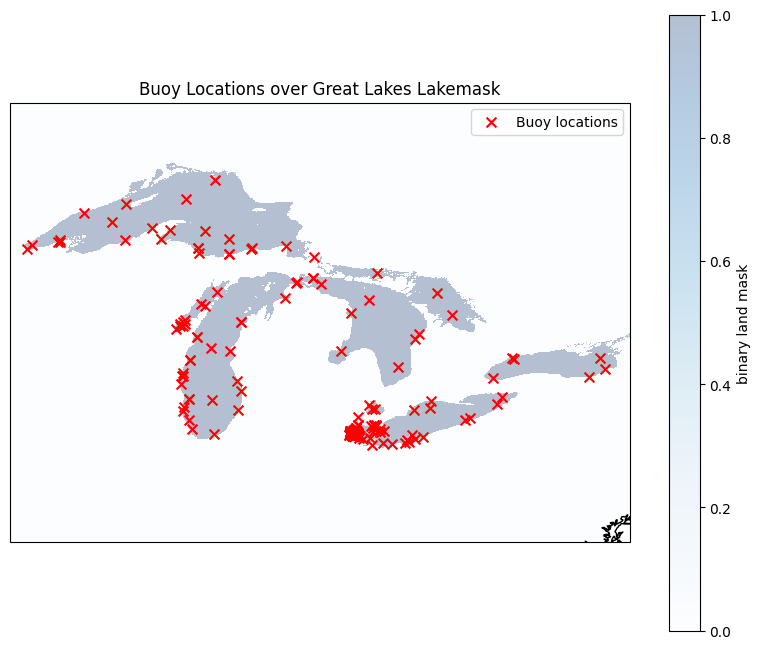

In [17]:
from deepsensor.active_learning import GreedyAlgorithm

# Configure to match X_s grid later
model.data_processor.config["coords"]["x1"]["name"] = "x1"
model.data_processor.config["coords"]["x2"]["name"] = "x2"

glsea_ds = glsea_raw.sel(time=val_dates).rename({'lat': 'x1', 'lon': 'x2'})
mask = lakemask_raw['mask'].rename({'lat': 'x1', 'lon': 'x2'})
print(mask)
sst = glsea_ds['sst'].transpose('x1', 'x2', 'time')

# To access internal grid operations
alg_temp = GreedyAlgorithm(
    model=model,
    X_s=glsea_ds,
    X_t=glsea_ds,
    X_s_mask=mask,
    X_t_mask=mask,
    proposed_infill=None,
    N_new_context=5,
    progress_bar=True,
    verbose=True,
)

#copy the grid to use proposed_infill
matching_grid = alg_temp.X_s['sst'].copy(deep=True)
matching_grid = matching_grid.astype(np.float32)
matching_grid = matching_grid.transpose('x1', 'x2', 'time')
matching_grid.load()
proposed_infill = matching_grid

#This time instantiate the algorithm
alg = GreedyAlgorithm(
    model=model,
    X_s=glsea_ds,
    X_t=glsea_ds,
    X_s_mask=mask,
    X_t_mask=mask,
    proposed_infill=proposed_infill,
    N_new_context=10,
    progress_bar=True,
    verbose=True,
)
#buoy-only sampling
netcdf_file_path = "gl_temp_data_cleaned.nc"

print(f"Loading dataset from: {netcdf_file_path}")
# Open the dataset. Xarray's default engine will handle it.
# Dask will automatically be used for lazy loading if the file is large,
# so you won't load the entire ~800MB into memory unless you compute something.
ds = xr.open_dataset(netcdf_file_path)
print(ds)
#making dataset with only unique locations
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values

coord_pairs = np.column_stack((latitudes, longitudes))
df_coords = pd.DataFrame(coord_pairs, columns=['lat', 'lon'])
df_unique = df_coords.drop_duplicates().dropna()

df_unique = df_unique.sort_values(by=["lat", "lon"]).reset_index(drop=True)

print(f"Found {len(df_unique)} unique buoy locations.")
print(df_unique.head())
df_unique = df_unique.rename(columns={'lat': 'x1', 'lon': 'x2'})
buoy_da = xr.Dataset(coords={'x1': (['points'], df_unique['x1']),
                             'x2': (['points'], df_unique['x2'])})

interpolated_mask = mask.interp(x1=buoy_da['x1'], x2=buoy_da['x2'])
on_lake = interpolated_mask.values == 1
df_unique = df_unique[on_lake].reset_index(drop=True)

print(f"{len(df_unique)} buoys remain after filtering to valid lakemask points.")

df = df_unique.copy()
df['dummy'] = 0  # Add dummy column
df = df.set_index(['x1', 'x2'])

X_c_normalized = data_processor(df, method="min_max").index.to_frame(index=False).values.T


#plotting our buoys
lats = df_unique['x1'].values
lons = df_unique['x2'].values

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=crs))

lakemask_raw['mask'].plot(ax=ax, transform=crs, cmap='Blues', alpha=0.3)
ax.scatter(
    lons, lats,
    transform=crs,
    color='red',
    s=50,
    marker='x',
    label='Buoy locations'
)

ax.coastlines(resolution='10m')
ax.set_title("Buoy Locations over Great Lakes Lakemask")
ax.legend()
plt.show()
# To Save in Batch Job
#plt.savefig("your_name.png")
#plt.close()

## Step 9: Standard Deviation Acquisition Function

The **Standard Deviation (Stddev)** acquisition function is used to guide the model towards uncertain regions. The idea is to select data points where the model has high variability in its predictions, which often indicates areas where the model is unsure.

We use the **Stddev** acquisition function to select uncertain data points during the active learning process.


In [18]:
from deepsensor.active_learning.acquisition_fns import Stddev
placement_dates = val_dates
placement_tasks = task_loader(placement_dates, context_sampling= [X_c_normalized, "all", "all", "all"], target_sampling="all", seed_override=42)


In [22]:
from tqdm import tqdm

model.data_processor.config["coords"]["x1"]["name"] = "x1"
model.data_processor.config["coords"]["x2"]["name"] = "x2"


acquisition_fn = Stddev(model)


X_base = X_c_normalized.copy()


truth = glsea_ds['sst'].sel(time=val_dates)
gbw = mask / mask.sum()

rmses, avgstds, nlls = [], [], []
pred_means, pred_stds = [], []

N_iters = 10

# Overwritten Active Learning Loop to show RMSE by iteration 
for i in tqdm(range(N_iters + 1), desc="Active Learning Loop"):
    placement_tasks = task_loader(
        val_dates,
        context_sampling=[X_base, "all", "all"],
        target_sampling="all"
    )

    model.data_processor.config["coords"]["x1"]["name"] = "lat"
    model.data_processor.config["coords"]["x2"]["name"] = "lon"
    X_t_array = proposed_infill.sel(time=val_dates).rename({'x1': 'lat', 'x2': 'lon'})
    X_t_array = X_t_array.assign_coords(lat=X_t_array['lat'], lon=X_t_array['lon'])
    X_t_grid = xr.Dataset({'sst': X_t_array})
    print(X_t_grid)
    pred = model.predict(placement_tasks, X_t=X_t_grid)
    mean_da = pred["sst"]["mean"]
    std_da = pred["sst"]["std"]
    pred_means.append(mean_da)
    pred_stds.append(std_da)

    err = mean_da - truth
    rmse = np.sqrt((err**2).weighted(gbw).mean()).values.item()
    avgstd = std_da.weighted(gbw).mean().values.item()

    std_da_safe = std_da.where(std_da > 1e-6, 1e-6)
    nll = (
        0.5 * np.log(2 * np.pi * std_da_safe ** 2) +
        0.5 * ((truth - mean_da) ** 2) / (std_da_safe ** 2)
    ).weighted(gbw).mean().values.item()

    rmses.append(rmse)
    avgstds.append(avgstd)
    nlls.append(nll)

    if i == N_iters:
        break

    X_new_df, _ = alg(acquisition_fn, placement_tasks)
    x1, x2 = X_new_df.iloc[0][["x1", "x2"]]

    df_new = pd.DataFrame({'x1': [x1], 'x2': [x2], 'dummy': [0]}).set_index(['x1', 'x2'])
    X_new_norm = data_processor(df_new, method="min_max").index.to_frame(index=False).values.T
    X_base = np.concatenate((X_base, X_new_norm), axis=1)

Active Learning Loop:   0%|          | 0/11 [00:00<?, ?it/s]

<xarray.Dataset> Size: 51MB
Dimensions:  (time: 13, lat: 838, lon: 1181)
Coordinates:
  * time     (time) datetime64[s] 104B 2010-01-01 2010-01-31 ... 2010-12-27
  * lat      (lat) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * lon      (lon) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
Data variables:
    sst      (lat, lon, time) float32 51MB nan nan nan nan ... nan nan nan nan


/home/nbernot/deepsensor_nb/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:
Active Learning Loop:   0%|          | 0/11 [00:56<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.59 GiB. GPU 0 has a total capacity of 15.77 GiB of which 260.19 MiB is free. Including non-PyTorch memory, this process has 15.51 GiB memory in use. Of the allocated memory 13.63 GiB is allocated by PyTorch, and 1.51 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(range(N_iters + 1), rmses, label='RMSE')
axs[0].set_title("RMSE over Iterations")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("RMSE")
axs[0].legend()

axs[1].plot(range(N_iters + 1), avgstds, label='Avg. Stddev', color='orange')
axs[1].set_title("Average Stddev over Iterations")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Stddev")
axs[1].legend()

axs[2].plot(range(N_iters + 1), nlls, label='NLL', color='green')
axs[2].set_title("Negative Log Likelihood over Iterations")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("NLL")
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
acquisition_fn_ds
print(acquisition_fn_ds)
print("Dimensions:", acquisition_fn_ds.dims)
print("Coordinates:", acquisition_fn_ds.coords)

## Step 10: Visualizing Active Learning Placements

After performing active learning, we visualize the new data points selected by the algorithm. These points are likely to be in areas where the model is most uncertain.

We plot the selected points on a map to visualize where the model has focused its attention.


In [ ]:
#These plots help visualize acquisition search grid and improvement
fig = deepsensor.plot.placements(placement_tasks[0], X_new_df, data_processor, crs=ccrs.PlateCarree())

data_processor.raw_spatial_coord_names = ["x1", "x2"]
fig = deepsensor.plot.acquisition_fn(
    placement_tasks[0],
    acquisition_fn_ds.sel(iteration=slice(0, 4)),
    X_new_df,
    data_processor,
    crs=ccrs.PlateCarree(),
    cmap="Greys",
    col_dim="iteration",
    figsize=10,
    max_ncol=2
)
# to save in batch job
#fig.savefig("your_name.png")

Although this plot isn't the easiest to read, it seems that the GreedyAlgorithm is recommending that we focus on Western Lake Erie, which is good to see, as this is exactly where the current network does have a high density of instruments. So to first order, the existing observing network isn't too bad. 

# Conclusion

In this notebook, we implemented active learning to improve model training by focusing on the most informative data points. We:
1. Loaded and preprocessed several datasets for training.
2. Used the **GreedyAlgorithm** to select uncertain data points for model training.
3. Visualized the placement of these points on the map.

Active learning helps ensure that the model is trained on the most challenging examples, which can improve its performance.


# Reproducibility

Below we list some aspects of the computing environment for better reproduciblity. 

In [ ]:
#Here we ignore the deepsensor matplotlib wrapper and use matplotlib to plot the relevant points only

no_repeats = []
for row in X_new_df.itertuples(index=False):
    x = row.x1
    y = row.x2
    if (x, y) not in no_repeats:
        no_repeats.append((x, y))

lats = [pt[0] for pt in no_repeats]
lons = [pt[1] for pt in no_repeats]

crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=crs))

lakemask_raw['mask'].plot(ax=ax, transform=crs, cmap='Blues', alpha=0.3)

ax.scatter(
    lons,
    lats,
    transform=crs,
    color='red',
    s=50,
    marker='x',
    label='Selected points'
)

ax.coastlines(resolution='10m')
ax.set_title('Points Needing Improvement')
ax.legend()

gl = ax.gridlines(
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
plt.show()
# to save in batch job
#plt.savefig("your_name.png")
#plt.close()

print("Python Executable:", sys.executable)
print("Python Version:", sys.version)
#!pip freeze > requirements.txt
#print("requirements.txt generated!")